# Mapping outcomes

This notebook creates maps of England and Wales to show the variation in outcomes from the different scenarios calculated earlier.

## Plain English summary

This notebook takes the outcome data we saved earlier and creates maps of England and Wales.

## Aim

Create maps to show:
+ change in added utility compared with no treatment
+ change in mean mRS score compared with no treatment
+ change in proportion of the population with an mRS score of 2 or less

for each of these cohorts:
+ nLVO treated with IVT
+ LVO treated with mixed methods
+ the treated ischaemic population

for each of these scenarios:
+ drip-and-ship
+ mothership


## Method

We load LSOA shapes from the Office for National Statistics and merge this geography data into the outcome data. Then we draw the shape of each LSOA with a colour that depends on the outcome value. All of the LSOAs on a map use the same range of colours so that they can be directly compared.

## Import packages

In [1]:
# import contextily as ctx
import geopandas
import numpy as np
import pandas as pd
import os

# For plotting:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import stroke_maps.load_data
import stroke_maps.catchment
import stroke_maps.geo  # to make catchment area geometry

pd.set_option('display.max_rows', 150)

In [2]:
dir_output = 'output'
limit_to_england = False

## Load data

### Load shape file

In [4]:
sa_gdf = stroke_maps.load_data.ni_sa_geography()
sa_gdf = sa_gdf.to_crs('EPSG:29902')

sa_gdf.head(3)

,OBJECTID,SA2011,SOA2011,X_COORD,Y_COORD,Hectares,Shape_Leng,Shape_Area,Code_all,geometry
0,1,N00000002,95AA01S2,315465,377176,169.044,8476.858446,1.690436e+06,N00000002,"POLYGON ((315481.125 376464.219, 315472.344 37..."
1,2,N00000004,95AA01S2,307147,376182,8700.040,46727.719482,8.700042e+07,N00000004,"POLYGON ((307740.812 382573.219, 307762.250 38..."
2,3,N00000007,95AA01S3,314461,383440,1287.990,21817.292006,1.287995e+07,N00000007,"POLYGON ((311363.312 385217.625, 311600.000 38..."


In [8]:
# Load country outline
outline = stroke_maps.load_data.ni_outline()
outline = outline.to_crs('EPSG:29902')

In [9]:
outline

,ID,DATASET,OSNI_SCALE,SHAPE_Length,SHAPE_Area,OBJECTID,geometry
0,6834691,Outline of Northern Ireland,1:50000,1.801673e+06,1.360305e+10,1,"MULTIPOLYGON (((312511.612 319450.819, 312511...."


### Load hospital info

Load in the stroke unit coordinates and merge in the services information:

In [10]:
df_units = stroke_maps.load_data.ni_stroke_unit_services()

df_units.head(3).T

Postcode,BT126BA,BT161RH,BT358DR
Hospital_name,Royal Victoria,Ulster,Daisy Hill
City,Belfast,Belfast,Newry
door_to_needle,43,50,38
Fixed,2.0,NaN,NaN
use_ivt,1,1,0
use_mt,1,0,0


In [11]:
hospitals_gdf = stroke_maps.load_data.stroke_unit_coordinates_ni()
hospitals_gdf = pd.merge(
    hospitals_gdf, df_units[['use_ivt', 'use_mt']],
    left_index=True, right_index=True, how='right'
)

In [12]:
hospitals_gdf.head(3)

,Hospital_name,City,square_letter,square_easting,square_northing,square_ref_easting,square_ref_northing,easting,northing,geometry,use_ivt,use_mt
Postcode,,,,,,,,,,,,
BT126BA,Royal Victoria,Belfast,J,32226,73709,300000,300000,332226,373709,POINT (332226.000 373709.000),1,1
BT161RH,Ulster,Belfast,J,41440,74272,300000,300000,341440,374272,POINT (341440.000 374272.000),1,0
BT358DR,Daisy Hill,Newry,J,7549,27085,300000,300000,307549,327085,POINT (307549.000 327085.000),0,0


### Load LSOA model output data

In [13]:
sa_data = pd.read_csv(os.path.join(dir_output, 'cohort_outcomes_weighted.csv'))
sa_data.head(3).T

,0,1,2
lsoa,N00000001,N00000002,N00000003
closest_ivt_time,19.032658,23.292278,20.471335
closest_ivt_unit,BT412RL,BT412RL,BT412RL
closest_mt_time,31.400562,24.67773,24.67773
closest_mt_unit,BT126BA,BT126BA,BT126BA
transfer_mt_time,28.748618,28.748618,28.748618
transfer_mt_unit,BT126BA,BT126BA,BT126BA
mt_transfer_required,True,True,True
ivt_drip_ship,109.032658,113.292278,110.471335
mt_drip_ship,257.781276,262.040896,259.219953


In [15]:
# Merge with shape file

sa_data_gdf = sa_gdf.merge(sa_data, left_on='SA2011', right_on='lsoa', how='right')

sa_data_gdf.head().T

,0,1,2,3,4
OBJECTID,7,1,4537,2,6
SA2011,N00000001,N00000002,N00000003,N00000004,N00000005
SOA2011,95AA01S1,95AA01S2,95AA01S2,95AA01S2,95AA01S2
X_COORD,315036,315465,316689,307147,311125
Y_COORD,380003,377176,378660,376182,381985
Hectares,540.076,169.044,500.21,8700.04,2063.96
Shape_Leng,12921.250935,8476.858446,12659.603928,46727.719482,22346.461488
Shape_Area,5400762.37063,1690435.75048,5002104.72589,87000415.751,20639552.7312
Code_all,N00000001,N00000002,N00000003,N00000004,N00000005
geometry,"POLYGON ((315795.0312999999 380324.1875, 31578...","POLYGON ((315481.125 376464.21880000085, 31547...","POLYGON ((315434.4062999999 378660.625, 315415...","POLYGON ((307740.8125 382573.21880000085, 3077...","POLYGON ((307740.8125 382573.21880000085, 3077..."


## Calculate difference between Mothership and Drip and Ship

In [16]:
cohort_names = ['nlvo_ivt', 'lvo_mix', 'weighted_treated']

outcome_names = ['added_utility', 'added_mrs_less_equal_2', 'mrs_shift']

In [17]:
cols_diff = [f'{c}_{o}_mothership_minus_dripship' for c in cohort_names for o in outcome_names]
cols_moth = [f'mothership_{c}_{o}' for c in cohort_names for o in outcome_names]
cols_drip = [f'drip_ship_{c}_{o}' for c in cohort_names for o in outcome_names]

sa_data_gdf[cols_diff] = sa_data_gdf[cols_moth].values - sa_data_gdf[cols_drip].values

## Basic plot

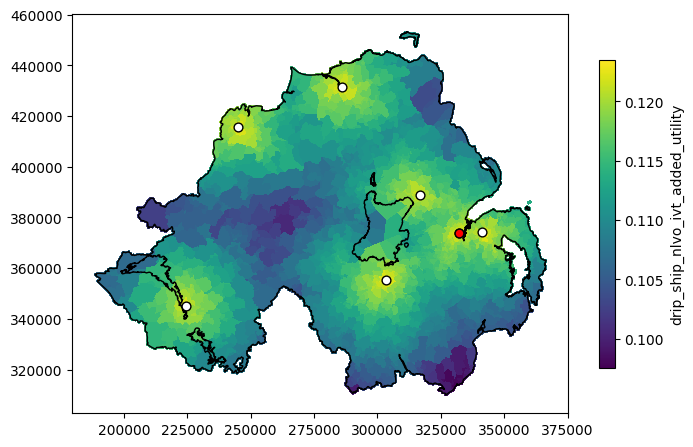

In [18]:
col = 'drip_ship_nlvo_ivt_added_utility'

# Figure setup:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot data
sa_data_gdf.plot(
    ax=ax,             # Set which axes to use for plot
    column=col,        # Column to apply colour
    antialiased=False, # Avoids artefact boundry lines
    edgecolor='face',  # Make LSOA boundary same colour as area
    # Adjust size of colourmap key, and add label
    legend_kwds={'shrink':0.5, 'label':col},
    legend=True,       # Set to display legend
)

# Add country border
outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)

# Add hospitals
mask = hospitals_gdf['use_ivt'] == 1
hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=40, marker='o')
mask = hospitals_gdf['use_mt'] == 1
hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='r', markersize=40, marker='o')

plt.show()

The extra outlines to the left and just right of centre are lakes.

## Plots

### Define functions

These functions find shared colour limits across multiple columns of data:

In [19]:
def find_vlims_scenarios(sa_data_gdf, data_field, cohorts):
    scenarios = ['drip_ship', 'mothership']
    # Colour limits for separate scenarios:
    cols = [f'{s}_{c}_{data_field}' for s in scenarios for c in cohorts]
    # Find maximum of data
    vmin = np.min([sa_data_gdf[col].min() for col in cols])
    vmax = np.max([sa_data_gdf[col].max() for col in cols])
    return vmin, vmax

def find_vlims_diff(sa_data_gdf, data_field, cohorts):
    # Colour limits for difference maps:
    cols = [f'{c}_{data_field}_mothership_minus_dripship' for c in cohorts]
    # Find absolute maximum of data extent
    vmax = np.max((np.abs([sa_data_gdf[col].min() for col in cols]),
                   np.abs([sa_data_gdf[col].max() for col in cols])))
    vmin = -vmax
    return vmin, vmax

This function plots the maps:

In [20]:
def plot_data(axs, cax, cax_diff, axs_cols, axs_params, colour_params):
    for row in range(len(axs_cols)):
        for col in range(len(axs_cols[row])):
            # Axis to plot on:
            ax = axs[row, col]
            # Data information:
            col_data = axs_cols[row][col]
            # Colour information:
            colour_params_type = axs_params[row][col]
            params = colour_params[colour_params_type]
            cbar_ax = cax if colour_params_type == 'shared' else cax_diff
            
            # Plot data
            sa_data_gdf.plot(
                ax=ax,
                column=col_data,      # Column to apply colour
                antialiased=False,    # Avoids artefact boundry lines
                edgecolor='face',     # Make LSOA boundry same colour as area
                vmin=params['vmin'],  # Manual scale min (remove to make automatic)
                vmax=params['vmax'],  # Manual scale max (remove to make automatic)
                cmap=params['cmap'],  # Colour map to use
                # Adjust size of colourmap key, and add label
                legend_kwds={'shrink':0.5, 'label':params['cbar_label']},
                legend=True,          # Set to display legend
                cax=cbar_ax
            )

These functions set up the figure and standard formatting across all axes:

In [26]:
def set_up_fig_nine():
    fig = plt.figure(figsize=(14, 18))

    # Set up GridSpec so that each map subplot takes up two gs subplots
    # in height. This lets the shared colourbar sit midway up two
    # subplots instead of being offset or twice the height of the other.
    gs = GridSpec(7, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.0, hspace=0.0)
    axs = np.array([
        [plt.subplot(gs[0:2, 0]), plt.subplot(gs[0:2, 1]), plt.subplot(gs[0:2, 2])],
        [plt.subplot(gs[2:4, 0]), plt.subplot(gs[2:4, 1]), plt.subplot(gs[2:4, 2])],
        [plt.subplot(gs[4:6, 0]), plt.subplot(gs[4:6, 1]), plt.subplot(gs[4:6, 2])],
    ])
    cax = plt.subplot(gs[1:3, -1])
    cax_diff = plt.subplot(gs[4:6, -1])
    return fig, axs, cax, cax_diff

def set_up_axis_and_extras(ax, outline, hospitals_gdf):
    # Add country border
    outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)
    
    # Add hospitals
    mask = hospitals_gdf['use_ivt'] == 1
    hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=40, marker='o')
    mask = hospitals_gdf['use_mt'] == 1
    hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='r', markersize=40, marker='o')

    # ax.set_axis_off() # Turn of axis line and numbers
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(False)

    # # Tighten map around mainland England and Wales
    # ax.set_xlim(120000)
    return ax

This function makes the plots for nine maps together:

In [27]:
def plot_nine(
        sa_data_gdf,
        axs_cols,
        axs_params,
        colour_params,
        hospitals_gdf,
        outline,
        col_titles=[],
        row_titles=[],
        savename=''
    ):
    fig, axs, cax, cax_diff = set_up_fig_nine()

    plot_data(axs, cax, cax_diff, axs_cols, axs_params, colour_params)

    for ax in axs.flatten():
        ax = set_up_axis_and_extras(ax, outline, hospitals_gdf)

    for i, row_title in enumerate(row_titles):
        axs[i, 0].set_ylabel(row_title, rotation=0, fontsize=14, labelpad=50.0)#, ha='right')
    for i, col_title in enumerate(col_titles):
        axs[0, i].set_xlabel(col_title, fontsize=14)
        axs[0, i].xaxis.set_label_position('top')
    
    plt.tight_layout(pad=1)
    if len(savename) > 0:
        plt.savefig(savename, dpi=300, bbox_inches='tight')
    plt.show()

### Draw the plots

Settings for the nine-in-one plot:

In [28]:
col_titles = ['nLVO', 'LVO', 'Treated ischaemic population']
row_titles = ['Drip and ship', 'Mothership', 'Advantage of\n mothership']

cohorts = ['nlvo_ivt', 'lvo_mix', 'weighted_treated']

axs_params = [
    ['shared'] * 3,
    ['shared'] * 3,
    ['diff'] * 3,
]

Settings for added utility:

In [29]:
data_field = 'added_utility'

vmin_scenarios, vmax_scenarios = find_vlims_scenarios(sa_data_gdf, data_field, cohorts)
vmin_diff, vmax_diff = find_vlims_diff(sa_data_gdf, data_field, cohorts)

params_added_utility = {
    'shared': {
        'vmin': vmin_scenarios,
        'vmax': vmax_scenarios,
        'cmap': 'inferno',
        'cbar_label': 'Added utility'
    },
    'diff': {
        'vmin': vmin_diff,
        'vmax': vmax_diff,
        'cmap': 'bwr_r',
        'cbar_label': 'Advantage of Mothership (added utility)'
    },
}

axs_cols_added_utility = [
    # First row:
    [f'drip_ship_nlvo_ivt_{data_field}',
     f'drip_ship_lvo_mix_{data_field}',
     f'drip_ship_weighted_treated_{data_field}'],
    # Second row:
    [f'mothership_nlvo_ivt_{data_field}',
     f'mothership_lvo_mix_{data_field}',
     f'mothership_weighted_treated_{data_field}'],
    # Third row:
    [f'nlvo_ivt_{data_field}_mothership_minus_dripship',
     f'lvo_mix_{data_field}_mothership_minus_dripship',
     f'weighted_treated_{data_field}_mothership_minus_dripship'],   
]

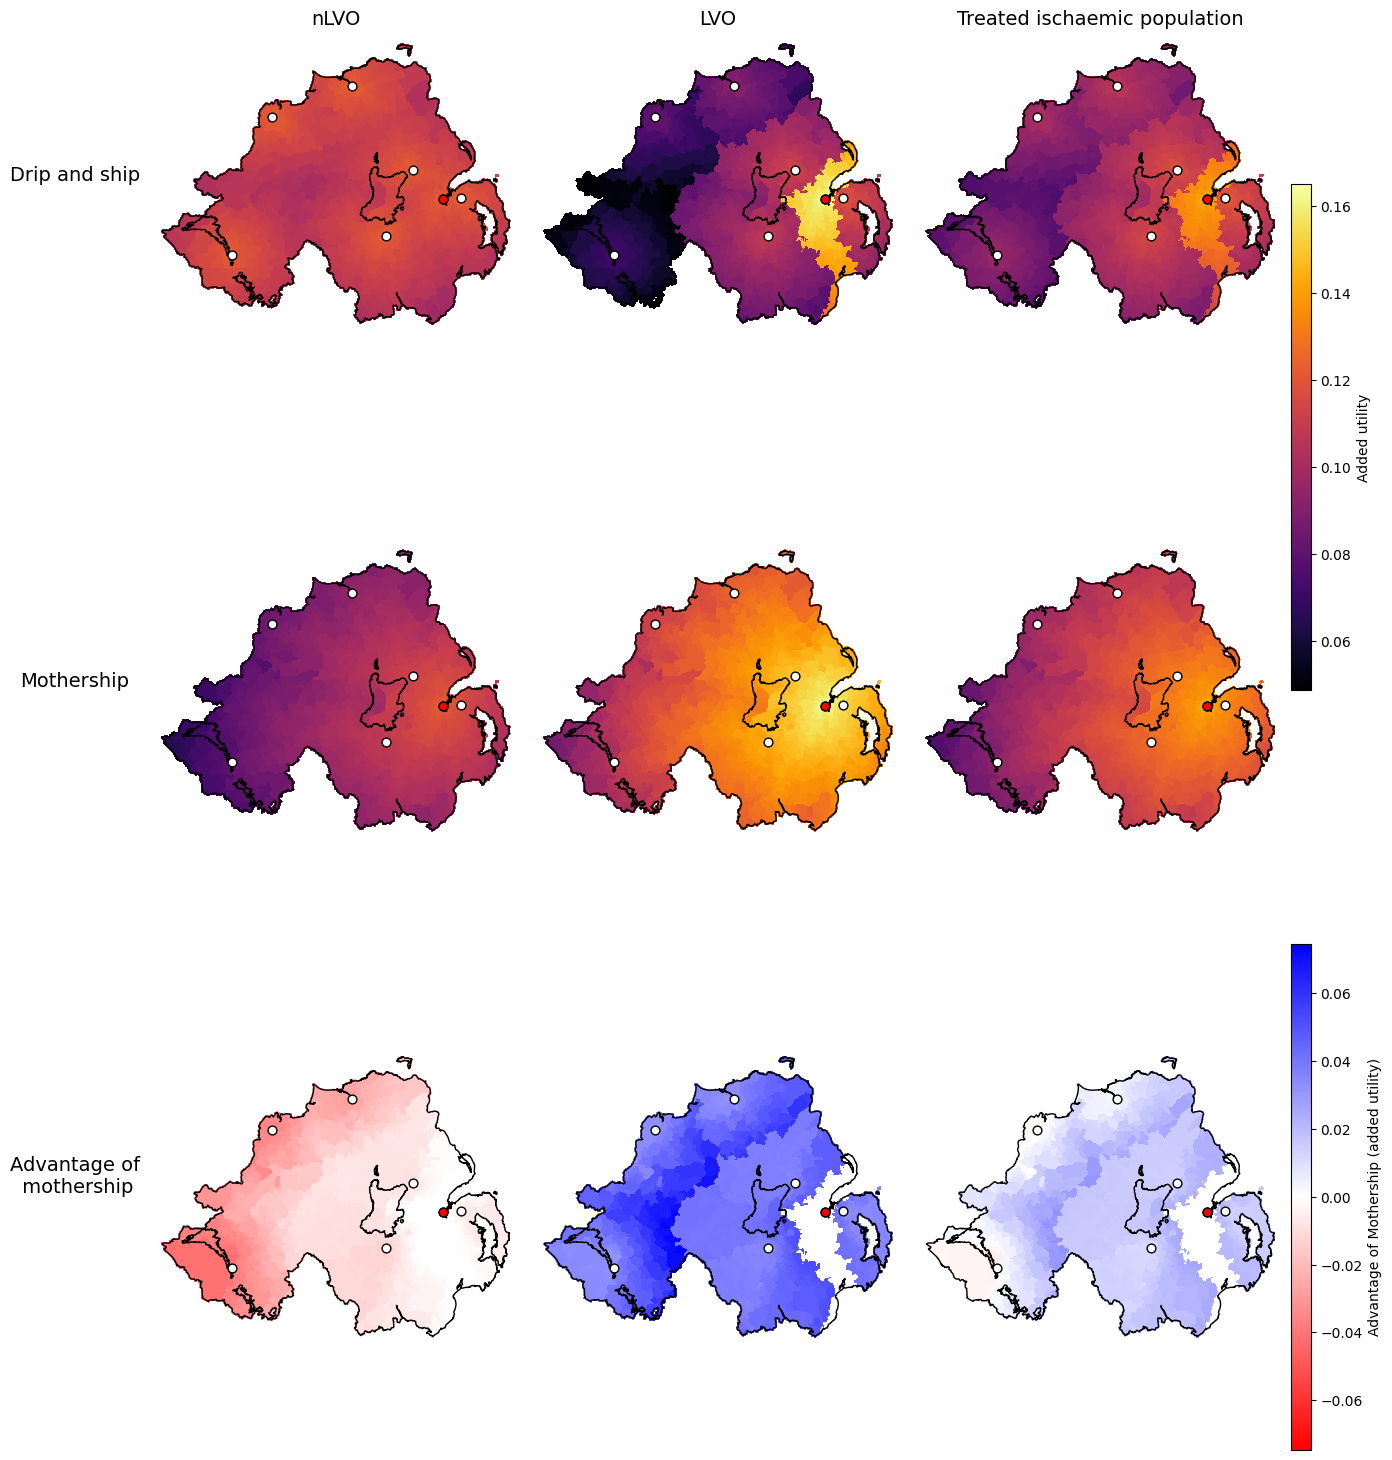

In [30]:
plot_nine(
    sa_data_gdf,
    axs_cols_added_utility,
    axs_params,
    params_added_utility,
    hospitals_gdf,
    outline,
    col_titles,
    row_titles,
    savename=os.path.join(dir_output, f'{data_field}_nine_in_one.jpg')
)

Settings for mRS shift:

In [31]:
data_field = 'mrs_shift'

vmin_scenarios, vmax_scenarios = find_vlims_scenarios(sa_data_gdf, data_field, cohorts)
vmin_diff, vmax_diff = find_vlims_diff(sa_data_gdf, data_field, cohorts)

params_mrs_shift = {
    'shared': {
        'vmin': vmin_scenarios,
        'vmax': vmax_scenarios,
        'cmap': 'inferno_r',
        'cbar_label': 'Mean mRS shift'
    },
    'diff': {
        'vmin': vmin_diff,
        'vmax': vmax_diff,
        'cmap': 'bwr',
        'cbar_label': 'Advantage of Mothership (mean mRS shift)'
    },
}

axs_cols_mrs_shift = [
    # First row:
    [f'drip_ship_nlvo_ivt_{data_field}',
     f'drip_ship_lvo_mix_{data_field}',
     f'drip_ship_weighted_treated_{data_field}'],
    # Second row:
    [f'mothership_nlvo_ivt_{data_field}',
     f'mothership_lvo_mix_{data_field}',
     f'mothership_weighted_treated_{data_field}'],
    # Third row:
    [f'nlvo_ivt_{data_field}_mothership_minus_dripship',
     f'lvo_mix_{data_field}_mothership_minus_dripship',
     f'weighted_treated_{data_field}_mothership_minus_dripship'],   
]

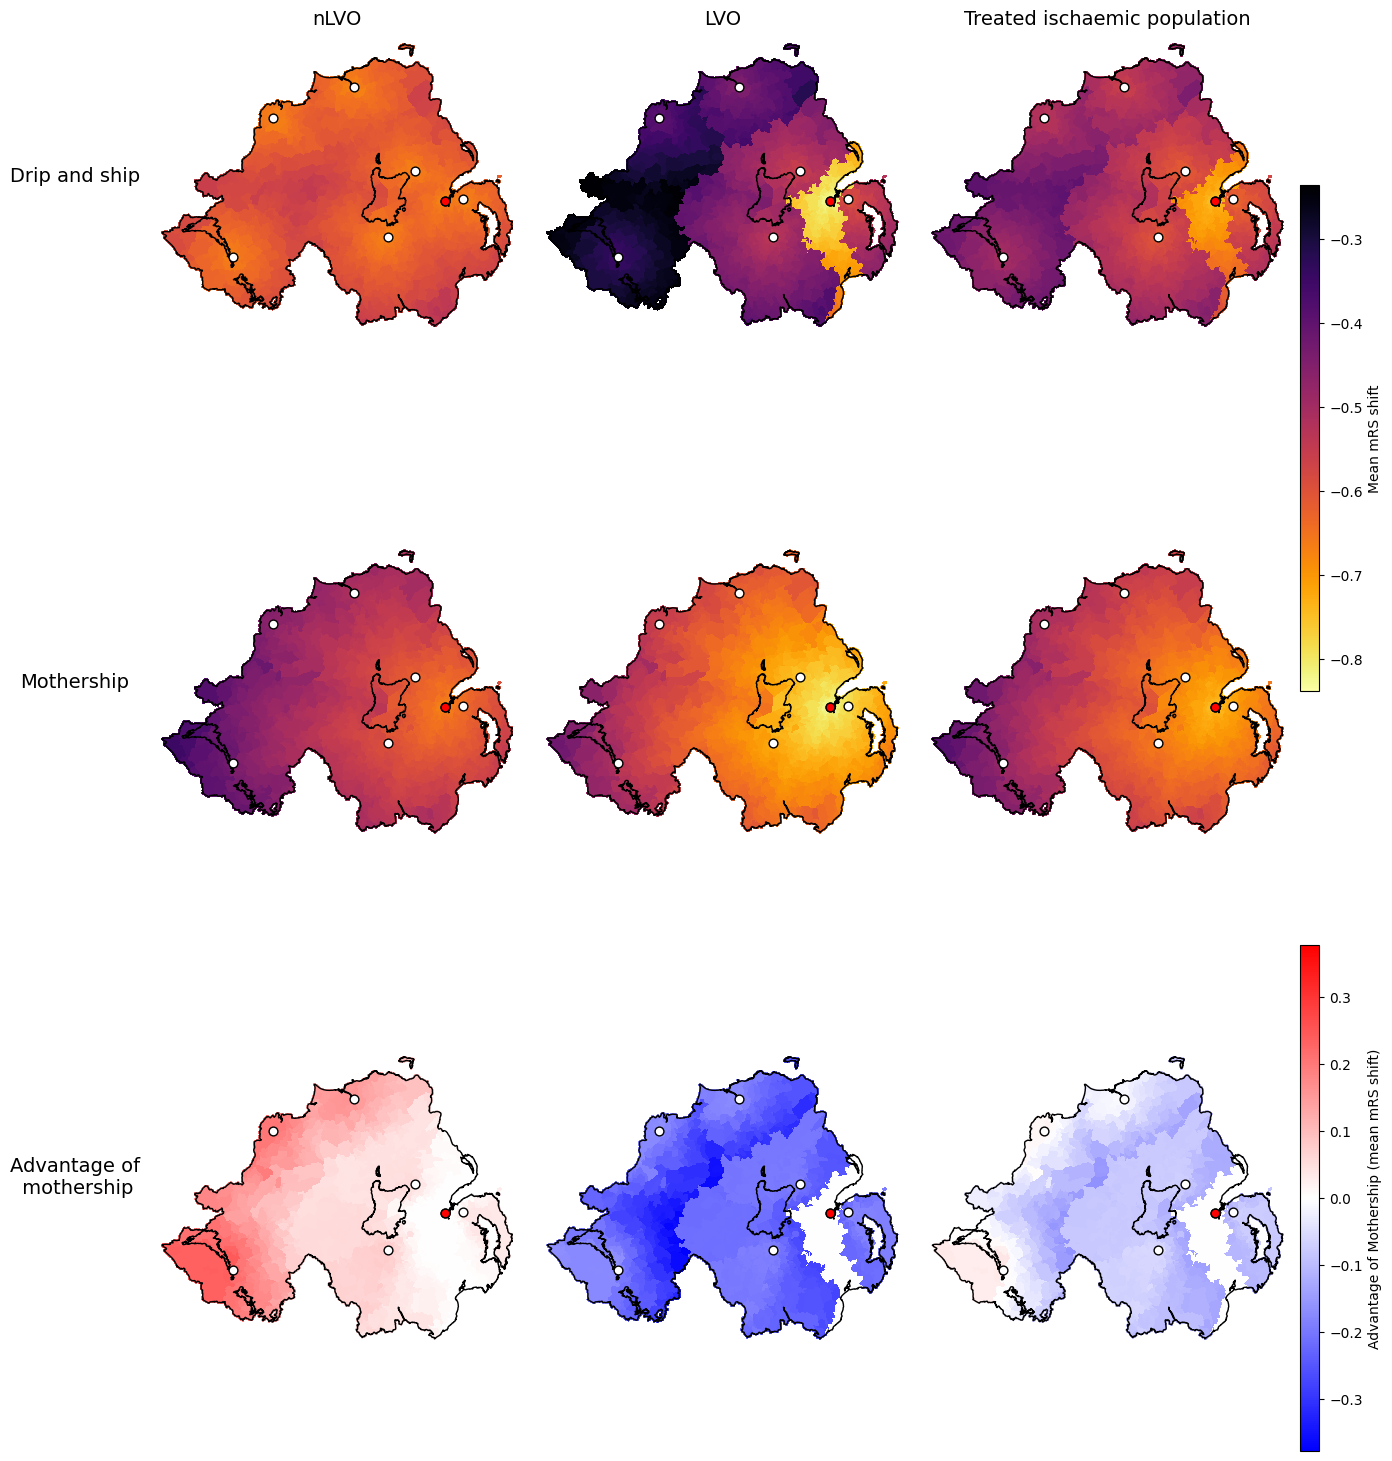

In [32]:
plot_nine(
    sa_data_gdf,
    axs_cols_mrs_shift,
    axs_params,
    params_mrs_shift,
    hospitals_gdf,
    outline,
    col_titles,
    row_titles,
    savename=os.path.join(dir_output, f'{data_field}_nine_in_one.jpg')
)

Settings for proportion with mRS less than or equal to 2:

In [33]:
data_field = 'added_mrs_less_equal_2'

vmin_scenarios, vmax_scenarios = find_vlims_scenarios(sa_data_gdf, data_field, cohorts)
vmin_diff, vmax_diff = find_vlims_diff(sa_data_gdf, data_field, cohorts)

params_added_mrs_less_equal_2 = {
    'shared': {
        'vmin': vmin_scenarios,
        'vmax': vmax_scenarios,
        'cmap': 'inferno',
        'cbar_label': r'Added mRS$\leq$2'
    },
    'diff': {
        'vmin': vmin_diff,
        'vmax': vmax_diff,
        'cmap': 'bwr_r',
        'cbar_label': r'Advantage of Mothership (added mRS$\leq$2)'
    },
}

axs_cols_added_mrs_less_equal_2 = [
    # First row:
    [f'drip_ship_nlvo_ivt_{data_field}',
     f'drip_ship_lvo_mix_{data_field}',
     f'drip_ship_weighted_treated_{data_field}'],
    # Second row:
    [f'mothership_nlvo_ivt_{data_field}',
     f'mothership_lvo_mix_{data_field}',
     f'mothership_weighted_treated_{data_field}'],
    # Third row:
    [f'nlvo_ivt_{data_field}_mothership_minus_dripship',
     f'lvo_mix_{data_field}_mothership_minus_dripship',
     f'weighted_treated_{data_field}_mothership_minus_dripship'],   
]

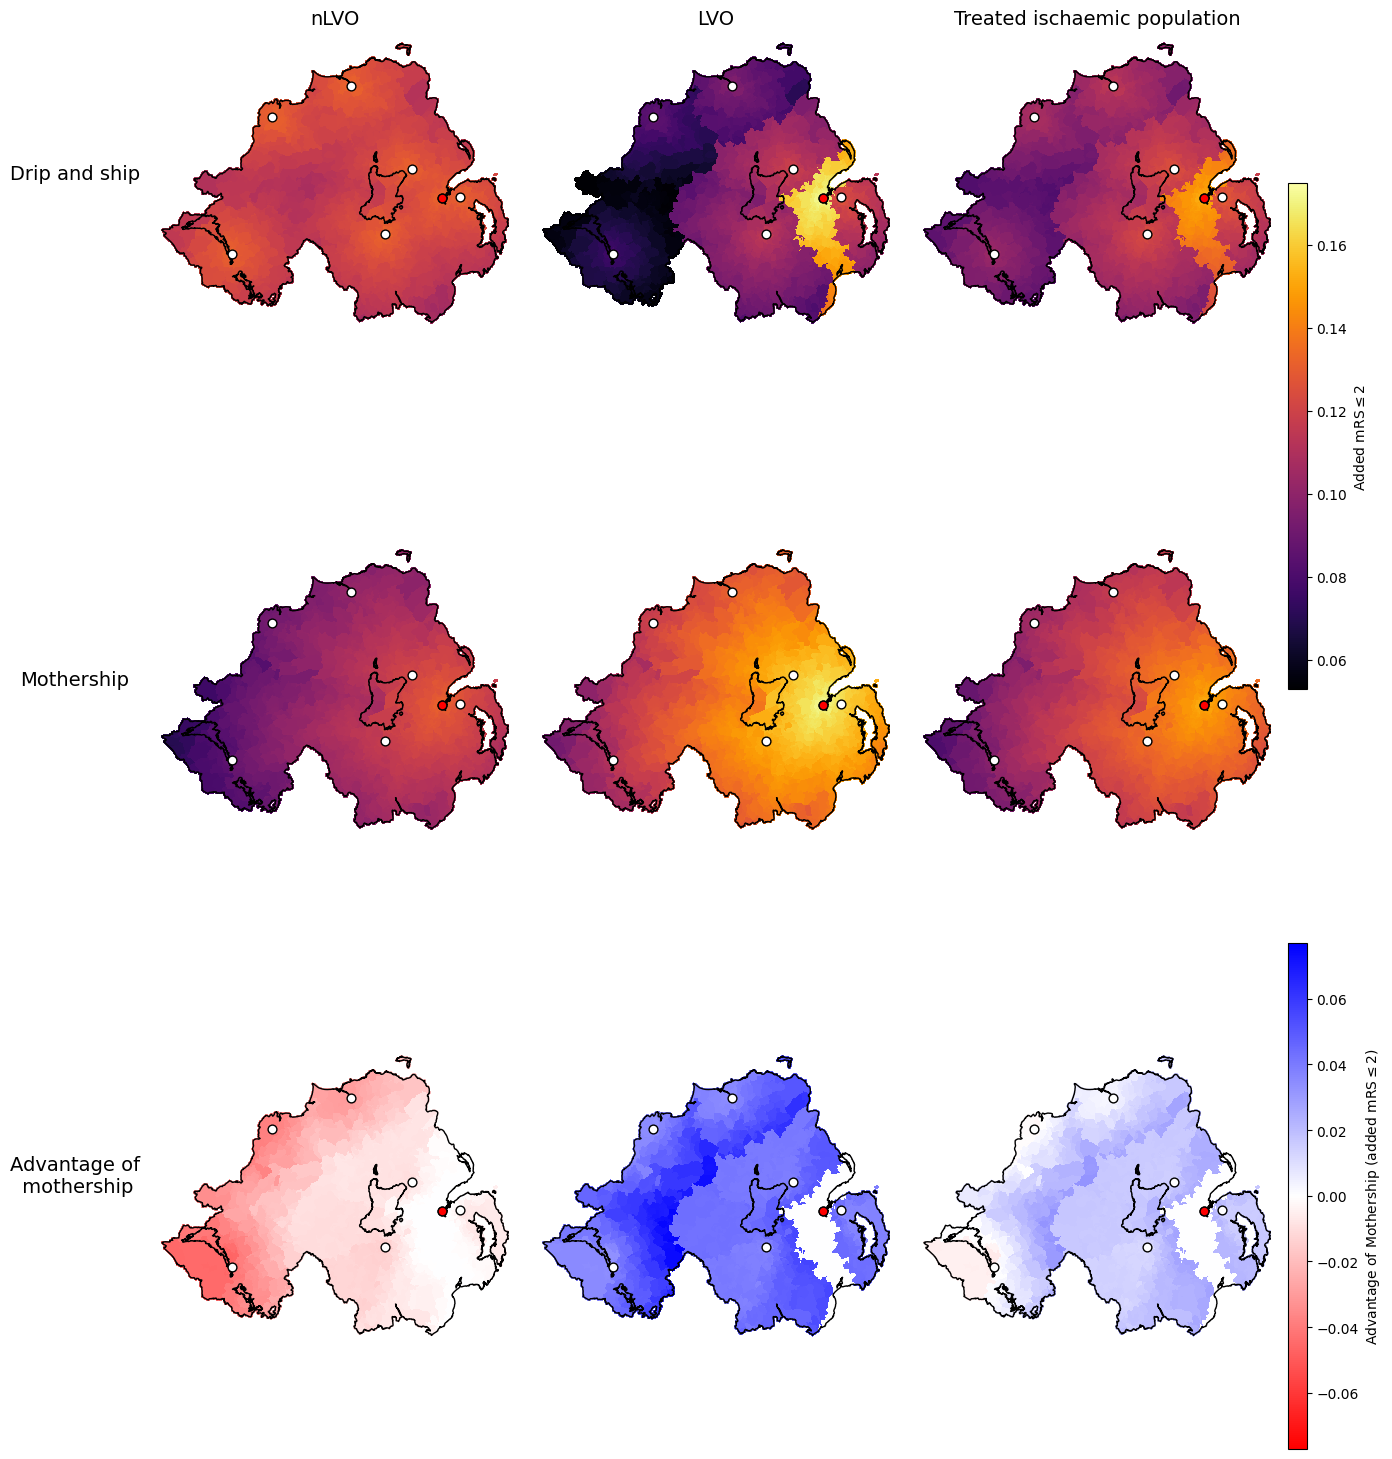

In [34]:
plot_nine(
    sa_data_gdf,
    axs_cols_added_mrs_less_equal_2,
    axs_params,
    params_added_mrs_less_equal_2,
    hospitals_gdf,
    outline,
    col_titles,
    row_titles,
    savename=os.path.join(dir_output, f'{data_field}_nine_in_one.jpg')
)

## Conclusion

The maps show similar results for the three outcome types: added utility, mean shift in mRS, and proportion with mRS score of 2 or less.

The advantage of mothership is worse for nLVO patients (the map is mostly red), better for LVO patients (the map is mostly blue), and generally slightly better overall for this mix of treated ischaemic patients.

Some parts of the combined treated ischaemic maps break the trend and have worse outcomes with mothership (drawn in red). The easiest to spot on this map is half-way up the west coast of Wales near Aberystwyth. The following notebook digs into these outlier areas more to see why they break the trend.